In [ ]:
import torch
import gradio as gr
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import load_image
from transformers import CLIPVisionModelWithProjection
from PIL import Image

# ==========================================
# 1. 모델 로드 (프로그램 시작 시 한 번만 실행)
# ==========================================
print("모델을 로드하는 중입니다. 잠시만 기다려 주세요...")

# 이미지 인코더
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter", subfolder="models/image_encoder", torch_dtype=torch.float16
).to("cuda")

# SDXL 파이프라인
pipeline = AutoPipelineForImage2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    image_encoder=image_encoder,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
).to("cuda")

# IP-Adapter 로드
pipeline.load_ip_adapter(
    "h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter-plus-face_sdxl_vit-h.bin"
)

print("모델 로드 완료! 프로그램을 시작합니다.")

# ==========================================
# 2. 이미지 생성 함수 정의 (버튼 클릭 시 실행)
# ==========================================
def generate_image(input_image, custom_prompt, strength_slider):
    """
    Gradio 인터페이스에서 입력을 받아 이미지를 생성하는 함수
    """
    if input_image is None:
        return None

    generator = torch.Generator(device="cuda").manual_seed(42)
    
    # 기본 광고 프롬프트에 사용자가 입력한 추가 프롬프트를 더함
    base_prompt = "hyper-realistic product photography, 8k resolution, raw photo, the object sitting on a rustic wooden table, beautiful texture, soft bokeh lighting, depth of field"
    final_prompt = f"{base_prompt}, {custom_prompt}"

    negative_prompt_text = "low quality, blurred, ugly, deformed, bad composition, text, watermark, cartoon, painting"

    # Gradio에서 받은 이미지는 PIL 포맷이므로 바로 사용
    init_image = input_image

    image = pipeline(
        prompt=final_prompt,
        negative_prompt=negative_prompt_text,
        image=init_image,             
        ip_adapter_image=init_image,  
        strength=strength_slider, # 슬라이더 값 적용
        guidance_scale=7.5,
        num_inference_steps=30, # 속도를 위해 30으로 조정 (품질 원하면 40-50)
        generator=generator
    ).images[0]
    
    return image

# ==========================================
# 3. Gradio 인터페이스 구성
# ==========================================
# 앱의 디자인과 입력 요소를 정의합니다.

with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🍌 나만의 AI 광고 스튜디오")
    gr.Markdown("이미지를 넣으면 고급스러운 나무 테이블 위 광고 사진으로 만들어줍니다.")
    
    with gr.Row():
        with gr.Column():
            # 입력 영역
            input_img_box = gr.Image(type="pil", label="여기에 제품 이미지를 올리세요 (예: 바나나)")
            prompt_box = gr.Textbox(label="추가 분위기 (선택사항)", placeholder="예: sunset mood, dark atmosphere")
            strength_slider = gr.Slider(minimum=0.6, maximum=0.95, value=0.8, step=0.05, label="배경 변경 강도 (높을수록 배경이 확실히 바뀜)")
            generate_btn = gr.Button("광고 만들기 ✨", variant="primary")
            
        with gr.Column():
            # 출력 영역
            output_img_box = gr.Image(label="생성된 광고 이미지")

    # 버튼 클릭 이벤트 연결
    # 버튼을 누르면 -> generate_image 함수가 실행되고 -> 결과가 출력 박스에 나옴
    generate_btn.click(
        fn=generate_image,
        inputs=[input_img_box, prompt_box, strength_slider],
        outputs=output_img_box
    )

# ==========================================
# 4. 프로그램 실행
# ==========================================
# share=True로 설정하면 외부에서 접속 가능한 링크가 생성됩니다 (L4 환경에서 유용)
demo.launch(share=True, server_name="0.0.0.0")


In [ ]:
import torch
import gradio as gr
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import load_image
from transformers import CLIPVisionModelWithProjection
from PIL import Image

# ==========================================
# 1. 모델 로드 (이미 로드했다면 이 부분은 주석 처리 가능)
# ==========================================
# pipeline 변수가 이미 메모리에 있는지 확인하고 없으면 로드
try:
    if pipeline:
        print("✅ 모델이 이미 로드되어 있습니다.")
except NameError:
    print("⏳ 모델을 로드 중입니다... (L4 기준 약 1~2분 소요)")
    
    # 1-1. 이미지 인코더
    image_encoder = CLIPVisionModelWithProjection.from_pretrained(
        "h94/IP-Adapter", subfolder="models/image_encoder", torch_dtype=torch.float16
    ).to("cuda")

    # 1-2. SDXL 파이프라인
    pipeline = AutoPipelineForImage2Image.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        image_encoder=image_encoder,
        torch_dtype=torch.float16,
        variant="fp16",
        use_safetensors=True
    ).to("cuda")

    # 1-3. IP-Adapter (Face Plus 버전)
    pipeline.load_ip_adapter(
        "h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter-plus-face_sdxl_vit-h.bin"
    )
    print("✅ 모델 로드 완료!")

# ==========================================
# 2. 이미지 생성 로직 (배경 합성 최적화)
# ==========================================
def generate_ad(input_image, prompt_text, strength, adapter_scale):
    if input_image is None:
        return None

    generator = torch.Generator(device="cuda").manual_seed(42)
    
    # [핵심] IP-Adapter의 영향력을 조절합니다.
    # 이 값이 낮을수록(0.5~0.6) 원본의 '흰 배경'을 무시하고, 프롬프트의 '테이블'을 잘 그립니다.
    pipeline.set_ip_adapter_scale(adapter_scale)

    # 프롬프트: 사용자가 입력한 내용이 없으면 기본 '테이블 위 광고' 프롬프트 사용
    base_prompt = "professional product photography, the object sitting on a rustic wooden table, soft bokeh background, blurred kitchen, high quality, 8k, realistic texture, cinematic lighting"
    if prompt_text:
        final_prompt = f"{base_prompt}, {prompt_text}"
    else:
        final_prompt = base_prompt

    # 네거티브 프롬프트: 만화 느낌과 흰 배경을 강력하게 방지
    negative_prompt = "cartoon, illustration, anime, painting, drawing, white background, simple background, flat color, low quality, distorted, watermark, text"

    image = pipeline(
        prompt=final_prompt,
        negative_prompt=negative_prompt,
        image=input_image,            
        ip_adapter_image=input_image, 
        strength=strength,      # 배경 변경 강도 (높을수록 배경이 잘 바뀜)
        guidance_scale=8.0,     # 프롬프트 충실도
        num_inference_steps=40, 
        generator=generator
    ).images[0]
    
    return image

# ==========================================
# 3. 쥬피터 노트북용 Gradio UI
# ==========================================
# 기존 실행된 UI가 있다면 닫고 새로 엽니다
try:
    demo.close()
except:
    pass

with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("### 🍌 나노 바나나 광고 스튜디오 (Jupyter Ver.)")
    gr.Markdown("흰 배경의 제품 이미지를 넣어주세요. **'원본 모양 유지력'을 낮추면** 배경이 더 잘 합성됩니다.")

    with gr.Row():
        with gr.Column():
            input_img = gr.Image(type="pil", label="원본 이미지 (흰배경 권장)")
            
            # 슬라이더 설정 (핵심 기능)
            strength = gr.Slider(0.5, 1.0, value=0.85, step=0.05, label="배경 교체 강도 (Strength)")
            scale = gr.Slider(0.1, 1.0, value=0.6, step=0.1, label="원본 모양 유지력 (Adapter Scale)")
            
            txt_prompt = gr.Textbox(label="추가 분위기 (선택사항 - 비워두기 권장)", placeholder="")
            btn_run = gr.Button("광고 생성하기", variant="primary")
        
        with gr.Column():
            output_img = gr.Image(label="결과 이미지")

    btn_run.click(fn=generate_ad, inputs=[input_img, txt_prompt, strength, scale], outputs=output_img)

# 쥬피터 노트북에서는 inline=True 옵션이 편리합니다.
# share=True를 하면 외부 접속 링크도 생성됩니다.
demo.launch(share=True, inline=True, debug=True)

In [ ]:
import torch
import matplotlib.pyplot as plt
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import load_image
from transformers import CLIPVisionModelWithProjection

# ==========================================
# 1. 모델 로드 (이미 로드되어 있다면 생략 가능)
# ==========================================
try:
    if pipeline:
        print("✅ 모델이 이미 로드되어 있습니다.")
except NameError:
    print("⏳ 모델을 로드 중입니다...")
    
    image_encoder = CLIPVisionModelWithProjection.from_pretrained(
        "h94/IP-Adapter", subfolder="models/image_encoder", torch_dtype=torch.float16
    ).to("cuda")

    pipeline = AutoPipelineForImage2Image.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        image_encoder=image_encoder,
        torch_dtype=torch.float16,
        variant="fp16",
        use_safetensors=True
    ).to("cuda")

    pipeline.load_ip_adapter(
        "h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter-plus-face_sdxl_vit-h.bin"
    )
    print("✅ 모델 로드 완료!")

# ==========================================
# 2. 이미지 생성 및 Plot 출력 함수
# ==========================================
def generate_and_show(image_path):
    # 이미지 로드
    init_image = load_image(image_path)
    
    generator = torch.Generator(device="cuda").manual_seed(42)
    
    # [핵심 설정 변경]
    # scale 0.5: 원본(흰배경)을 덜 참고하고 바나나 느낌만 가져감
    pipeline.set_ip_adapter_scale(0.5) 
    
    # 프롬프트: 'dark' 키워드를 넣어 흰색 배경과 대비를 줌
    prompt = "A ripe banana lying on a dark vintage wooden table. Cinematic lighting, dramatic shadows, realistic food photography, 8k, bokeh background."
    
    # 네거티브: 흰색과 만화 느낌을 강력하게 배제
    negative_prompt = "white background, simple background, bright background, cartoon, illustration, anime, drawing, flat color, floating"

    # 이미지 생성
    result = pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=init_image,
        ip_adapter_image=init_image,
        
        # [중요] Strength 0.92
        # 1.0에 가까울수록 원본(흰색)을 무시하고 새로 그림.
        # 흰 배경을 없애려면 0.9 이상 줘야 함.
        strength=0.92, 
        
        guidance_scale=9.0,      # 프롬프트(나무 테이블)를 강하게 따름
        num_inference_steps=50,  # 고화질을 위해 스텝 수 증가
        generator=generator
    ).images[0]
    
    # Jupyter에서 바로 이미지를 보여주는 코드 (Matplotlib)
    plt.figure(figsize=(15, 8))
    
    # 원본
    plt.subplot(1, 2, 1)
    plt.title("Original Input")
    plt.imshow(init_image)
    plt.axis("off")
    
    # 결과
    plt.subplot(1, 2, 2)
    plt.title("Generated Result (On Table)")
    plt.imshow(result)
    plt.axis("off")
    
    plt.show() # 화면에 출력

# ==========================================
# 3. 실행
# ==========================================
# 가지고 계신 이미지 파일명을 넣으세요
generate_and_show("image.png")

🚀 '나노 바나나' 파이프라인 시작: image.png

[Stage 1] 배경 제거 AI 모델 로딩 중... (BiRefNet)
✂️ 바나나 분리 작업 수행 중...
🧹 GPU 메모리 정리 완료

[Stage 2] 배경 생성 AI 모델 로딩 중... (SDXL Inpainting)


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.38it/s]


🎨 새로운 배경(나무 테이블) 그리는 중...


100%|██████████| 40/40 [00:14<00:00,  2.68it/s]


🧹 GPU 메모리 정리 완료

[Stage 3] 최종 합성 및 결과 출력


/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/IPython/core/py

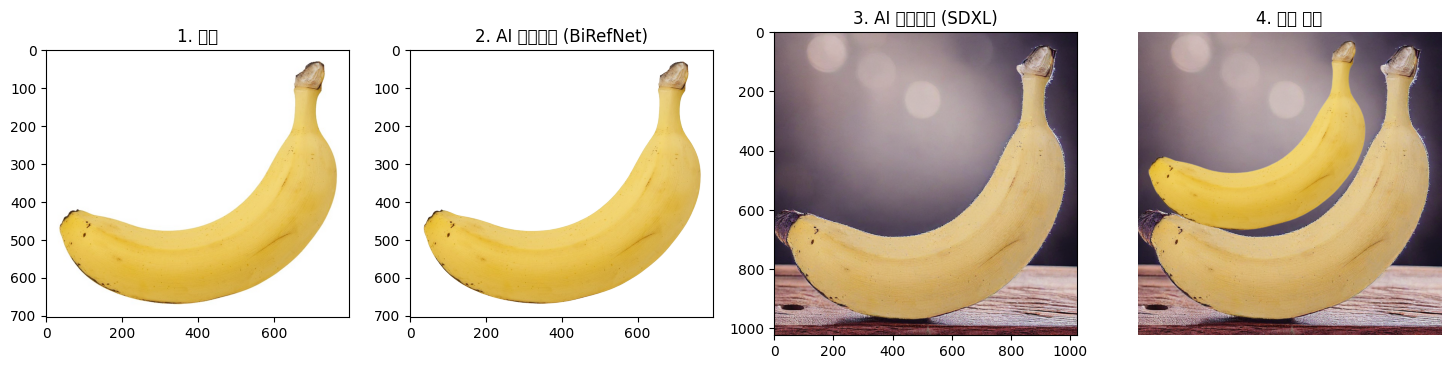

✅ 처리 완료! 결과 저장됨: nano_banana_result.png


In [3]:
import torch
import gc
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from transformers import AutoModelForImageSegmentation
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image

# ==========================================
# 🛠️ 유틸리티 함수: GPU 메모리 청소기
# ==========================================
def flush_memory():
    """모델을 내리고 GPU 메모리를 강제로 비웁니다."""
    gc.collect()
    torch.cuda.empty_cache()
    print("🧹 GPU 메모리 정리 완료")

# ==========================================
# 🚀 STAGE 1: AI 배경 제거 (BiRefNet)
# ==========================================
def step1_remove_background(image_path):
    print("\n[Stage 1] 배경 제거 AI 모델 로딩 중... (BiRefNet)")
    
    # 1. 모델 로드
    birefnet = AutoModelForImageSegmentation.from_pretrained(
        "ZhengPeng7/BiRefNet", 
        trust_remote_code=True
    )
    birefnet.to("cuda")
    birefnet.eval()
    
    # 2. 이미지 처리
    print("✂️ 바나나 분리 작업 수행 중...")
    original_img = load_image(image_path).convert("RGB")
    w, h = original_img.size
    
    # 이미지 전처리 (모델 입력용 리사이징 및 텐서 변환)
    transform_image = transforms.Compose([
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform_image(original_img).unsqueeze(0).to("cuda")
    
    # 3. 추론 (Inference)
    with torch.no_grad():
        preds = birefnet(input_tensor)[-1].sigmoid().cpu()
    
    # 4. 마스크 생성
    pred = preds[0].squeeze()
    pred_pil = transforms.ToPILImage()(pred)
    mask = pred_pil.resize((w, h))
    
    # 5. 투명 배경 이미지 생성 (Foreground)
    foreground = original_img.copy()
    foreground.putalpha(mask)
    
    # 6. 모델 메모리 해제
    del birefnet
    flush_memory()
    
    return original_img, foreground, mask

# ==========================================
# 🚀 STAGE 2: AI 배경 생성 (SDXL Inpainting)
# ==========================================
def step2_generate_background(original_img, mask_image):
    print("\n[Stage 2] 배경 생성 AI 모델 로딩 중... (SDXL Inpainting)")
    
    # 1. 모델 로드
    pipeline = AutoPipelineForInpainting.from_pretrained(
        "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
        torch_dtype=torch.float16,
        variant="fp16",
        use_safetensors=True
    ).to("cuda")
    
    # 2. 마스크 반전 처리
    # BiRefNet은 바나나를 흰색으로 잡지만, Inpainting 모델은 흰색을 '지우고 그릴 곳'으로 인식합니다.
    # 따라서 마스크를 뒤집어야 합니다 (검은색=바나나보존, 흰색=배경그리기).
    inverted_mask = Image.eval(mask_image, lambda x: 255 - x)
    
    # 3. 생성 (Inference)
    print("🎨 새로운 배경(나무 테이블) 그리는 중...")
    generator = torch.Generator(device="cuda").manual_seed(42)
    
    prompt = "high quality product photography, a banana sitting on a rustic wooden table, soft sunlight, bokeh background of a kitchen, 8k resolution, realistic textures, shadows, depth of field"
    negative_prompt = "cartoon, illustration, floating, bad composition, white background, deformed, watermark, text, ugly, distorted"
    
    generated_image = pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=original_img,    
        mask_image=inverted_mask, # 배경 부분만 새로 그림
        strength=1.0,             # 100% 새로 그림
        guidance_scale=7.5,
        num_inference_steps=40,
        generator=generator
    ).images[0]
    
    # 4. 모델 메모리 해제
    del pipeline
    flush_memory()
    
    return generated_image

# ==========================================
# 🏁 메인 실행 함수 (파이프라인 통합)
# ==========================================
def run_nano_banana_pipeline(image_path):
    print(f"🚀 '나노 바나나' 파이프라인 시작: {image_path}")
    
    # [1단계] 배경 제거
    original, foreground, mask = step1_remove_background(image_path)
    
    # [2단계] 배경 생성
    bg_generated = step2_generate_background(original, mask)
    
    # [3단계] 최종 합성 (Sharpness Trick)
    # AI가 생성한 이미지 위에, 1단계에서 딴 깔끔한 바나나를 덮어씌움
    print("\n[Stage 3] 최종 합성 및 결과 출력")
    final_result = bg_generated.copy()
    final_result.paste(foreground, (0, 0), foreground)
    
    # 결과 시각화
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 4, 1); plt.imshow(original); plt.title("1. 원본")
    plt.subplot(1, 4, 2); plt.imshow(foreground); plt.title("2. AI 배경제거 (BiRefNet)")
    plt.subplot(1, 4, 3); plt.imshow(bg_generated); plt.title("3. AI 배경생성 (SDXL)")
    plt.subplot(1, 4, 4); plt.imshow(final_result); plt.title("4. 최종 결과")
    plt.axis("off")
    plt.show()
    
    # 파일 저장
    final_result.save("nano_banana_result.png")
    print("✅ 처리 완료! 결과 저장됨: nano_banana_result.png")

# 실행
run_nano_banana_pipeline("image.png")